In [6]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os
import re
import json

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px
from scipy import stats

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, accuracy_score, mean_squared_error, mean_absolute_error, r2_score, classification_report # Metricas
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Guardar modelos
import pickle

# Models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# WoE
from category_encoders import *

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# Plot de matriz de confusion normalizada en actuals
#from utils import plot_confusion_matrix, get_artifact_filename

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from functools import partial

#Guardado de objetos en archivos joblib
from joblib import load, dump


from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('spanish'))
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_excel('../dataset_2023.xlsx')
df.head(2)

,Tipo comp.,NÂ° cuenta,Desc. Cuenta,NÂ° TesorerÃ­a,Desc. TesorerÃ­a,NÂ° Entidad,Desc. Entidad,Tipo Pres.,Tipo Reg.,Clase Reg.,Cod.,Fte. Fin.,Cuit,Beneficiario,Descripcion,Tipo cta,Cod. Bco.,Class
0,AF,360000003873122,SGP-RENTAS GRALES-PAGADORA ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,ANT,,229,10,30517999551,CAJA POPULAR DE AHORROS DE LA PROVINCIA DE TUC...,AFR-PLAN DE OBRAS- EQUIPAMIENTOS Y SERVICIOS 2022,R,7,ANR
1,AF,71111333,SGP - CTA PAGADORA- CHEQUES DIFERIDOS ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,ANT,,229,10,30517999551,CAJA POPULAR DE AHORROS DE LA PROVINCIA DE TUC...,D-312-ME-22-FONDOS P-EROGACIONES PLAN OBRAS,P,7,PTE


In [3]:
import spacy
import re
from nltk.corpus import stopwords
stop_words = list(stopwords.words('spanish'))  ### dos formas de atacar las stopwords: con esta lista o con la libreria spacy.

# Cargar modelo en español (puedes cambiar el modelo a inglés si es necesario)
nlp = spacy.load("es_core_news_sm")

In [27]:
def lematizacion(text):
  """
  no stop words + lematizacion
  """
  clean_text = []
  
  for token in nlp(text):
    if (
        not token.is_stop             # Excluir stop words
        and (token.is_alpha or token.is_digit)  # Incluir solo letras o números
        and not token.is_punct        # Excluir signos de puntuación
        and not token.like_url        # Excluir URLs
        
    ):
        clean_text.append(token.lemma_.upper())  

  return " ".join(clean_text)

In [22]:
def solo_numeros_y_letras(text):
    # Reemplazar todo lo que no sea letra o número por un espacio
    text_limpio = re.sub(r'[^a-zA-Z0-9áéíóúÁÉÍÓÚñÑ]', ' ', str(text))
    return text_limpio

In [9]:
def separar_texto_de_numeros(texto):
    # Expresión regular para insertar un espacio entre letras y números
    texto = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', texto)
    texto = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', texto)
    return texto

In [4]:
def remove_stopwords(text):
    """
    Elimino stopwords en español.
    """
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])


In [15]:
def eliminar_espacios_adicionales(texto):
    # Reemplazar múltiples espacios por un solo espacio
    texto_limpio = ' '.join(texto.split())
    return texto_limpio

In [33]:
def filtrar_palabras_numeros(texto):
    # Expresión regular para encontrar palabras o números con al menos 3 caracteres
    palabras_filtradas = re.findall(r'\b\w{3,}\b', texto)
    return " ".join(palabras_filtradas)

In [ ]:
def eliminar_palabras(texto):
    texto = texto.upper()
    texto = re.findall(r"(?!CTA)(?!RES)(?!PAGO)(?!AGO)(?!PAG)[A-Z0-9]{3,}", texto)
    texto = list(dict.fromkeys(texto))
    texto = " ".join(texto).strip()
    return texto

In [34]:
def pre_procesamiento_texto(text):
  """
  FIJATE QUE NO USE REGEX PARA SACAR PALABRAS CLAVE, Y LOS MODELOS ME DIERON PREDICCION BUENISIMA.
  """
  
  # Quito simbolos
  texto = solo_numeros_y_letras(text)
  
  # tokenizacion
  texto = separar_texto_de_numeros(texto)
  
  # Elimino espacios de mas
  texto = eliminar_espacios_adicionales(texto)
  
  # Elimino stopwords
  texto = remove_stopwords(texto)
  
  # Lematizacion
  texto = lematizacion(texto)
  
  # Solo palabras y numeros con minimo de 3 caracteres
  texto = filtrar_palabras_numeros(texto)
  
  # Eliminar palabras frecuentas: RES-CTA- etc.
  # texto = eliminar_palabras(texto)
  
  return texto

In [35]:
df["texto_limpio"] = df["Descripcion"].apply(pre_procesamiento_texto)


In [38]:
Class = list(df.Class.unique())
clases = {val:Class.index(val) for val in Class}
def get_class(val):
    return clases[val]

df['target'] = df['Class'].apply(get_class)

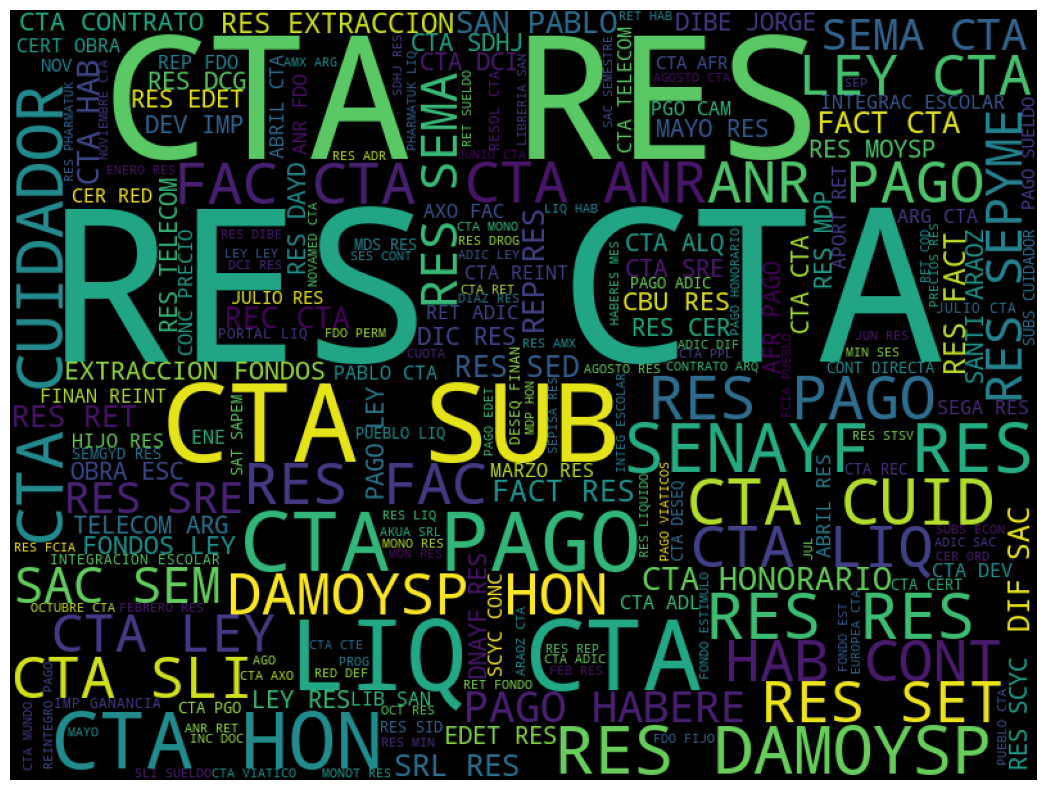

[('res', 91), ('combustible', 80), ('dcg', 79), ('360000002344074', 18), ('noviembre', 12), ('360000002606053', 12), ('dic', 12), ('marzo', 10), ('octubre', 9), ('ene', 9)]


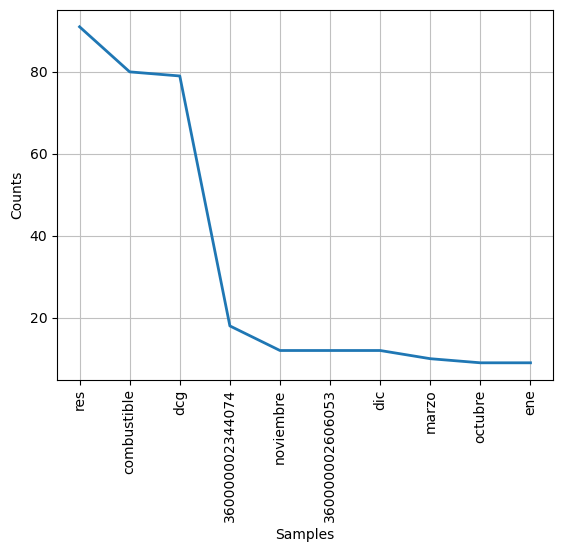

<Axes: xlabel='Samples', ylabel='Counts'>

In [41]:
################### BORRRARRRRRRRRR ######################
import nltk
from nltk.probability import FreqDist
#text = "hola miundo como estas estas"
#nltk.tokenize.word_tokenize(text)
# Concatenar todas las filas de la columna 'texto_limpio' en un solo texto
# combined_text = ' '.join(df['texto_limpio'].astype(str))
combined_text = ' '.join(df[df['target'] == 10]['texto_limpio'].astype(str))



# Tokenizar el texto en palabras
tokens = word_tokenize(combined_text.lower())  # Convertir a minúsculas para contar sin distinción de mayúsculas

# Crear la distribución de frecuencias
fdist = FreqDist(tokens)

# Mostrar las 10 palabras más comunes
print(fdist.most_common(10))

# Graficar la distribución de frecuencias
fdist.plot(10, cumulative=False)

In [42]:
# onehot encoding
categ = ['Tipo comp.','Tipo Reg.','Clase Reg.','Tipo cta']
for col in categ:
    df = df.join(pd.get_dummies(df[[col]]))
    df.drop(col, axis=1, inplace=True)



In [44]:

def pesos(texto, dic_words):
    texto = texto.lower()
    palabras = texto.split(' ')
    score = 0
    for palabra in palabras:
        if palabra in dic_words.keys():
            score += dic_words[palabra]
            #print(palabra)
    return score
dictOfWords = {}
for target in df.target.unique():
    df_target = df[df["target"]==target]
    all_descriptions = ' '.join(df_target['texto_limpio'].dropna())  # Concatenar todas las descripciones

    # Tokenización y eliminación de stopwords
    stop_words = set(stopwords.words('spanish')) 
    word_tokens = word_tokenize(all_descriptions.lower())  # Tokenización y convertir a minúsculas
    filtered_words = [word for word in word_tokens if word.isalnum() and word not in stop_words]  # Filtrar stopwords y no palabras alfa
    freq_of_words = pd.Series(filtered_words).value_counts()
    
    
    dic_words = freq_of_words.to_dict()
    dictOfWords[str(target)] = dic_words
    df[f'pesos_{target}'] = df['texto_limpio'].apply(pesos,dic_words=dic_words)

with open('dict_words_ivan.json', 'w') as file:
    json.dump(dictOfWords, file, indent=4)

In [45]:
features = []
for x in enumerate(df.dtypes):
    if x[1] in ["float64","int64","bool"]:
        features.append(df.columns[x[0]])

remove = [ 'Cuit Pago','dias_pago','target','index', 'Cta. Cte','NÂ° cta. Safyc','CuentaSafyc','NÂ° Comp.', 
          'NÂ° TesorerÃ\xada', 'NÂ° Pago','F. Anulado','F. Revertido', 'Cuit alt.','Id. Pe. Ch.','Monto', 'NÂ° Orig.',]

for col in remove:
    try:
        features.remove(col)
    except: pass
features

['NÂ° cuenta',
 'NÂ° Entidad',
 'Cod.',
 'Fte. Fin.',
 'Cuit',
 'Cod. Bco.',
 'Tipo comp._AF',
 'Tipo comp._FF',
 'Tipo comp._GA',
 'Tipo comp._GC',
 'Tipo comp._GE',
 'Tipo Reg._AMP',
 'Tipo Reg._ANT',
 'Tipo Reg._APE',
 'Tipo Reg._CYO',
 'Tipo Reg._ORD',
 'Tipo Reg._PAG',
 'Tipo Reg._RPO',
 'Clase Reg._   ',
 'Clase Reg._DPU',
 'Clase Reg._OGA',
 'Clase Reg._REM',
 'Tipo cta_P',
 'Tipo cta_R',
 'pesos_0',
 'pesos_1',
 'pesos_2',
 'pesos_3',
 'pesos_4',
 'pesos_5',
 'pesos_6',
 'pesos_7',
 'pesos_8',
 'pesos_9',
 'pesos_10',
 'pesos_11',
 'pesos_12',
 'pesos_13',
 'pesos_14',
 'pesos_15',
 'pesos_16',
 'pesos_17',
 'pesos_18',
 'pesos_19',
 'pesos_20',
 'pesos_21',
 'pesos_22',
 'pesos_23',
 'pesos_24',
 'pesos_25',
 'pesos_26']

In [46]:
X = df[features]

In [47]:
SEED = 12345
TEST_SIZE = 0.2


for col in X.columns:
    if X[col].dtype == 'object':
       X[col] = pd.to_numeric(X[col], errors='coerce')
y = df.target

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [48]:
X.isna().sum()

NÂ° cuenta        0
NÂ° Entidad       0
Cod.              0
Fte. Fin.         0
Cuit              0
Cod. Bco.         0
Tipo comp._AF     0
Tipo comp._FF     0
Tipo comp._GA     0
Tipo comp._GC     0
Tipo comp._GE     0
Tipo Reg._AMP     0
Tipo Reg._ANT     0
Tipo Reg._APE     0
Tipo Reg._CYO     0
Tipo Reg._ORD     0
Tipo Reg._PAG     0
Tipo Reg._RPO     0
Clase Reg._       0
Clase Reg._DPU    0
Clase Reg._OGA    0
Clase Reg._REM    0
Tipo cta_P        0
Tipo cta_R        0
pesos_0           0
pesos_1           0
pesos_2           0
pesos_3           0
pesos_4           0
pesos_5           0
pesos_6           0
pesos_7           0
pesos_8           0
pesos_9           0
pesos_10          0
pesos_11          0
pesos_12          0
pesos_13          0
pesos_14          0
pesos_15          0
pesos_16          0
pesos_17          0
pesos_18          0
pesos_19          0
pesos_20          0
pesos_21          0
pesos_22          0
pesos_23          0
pesos_24          0
pesos_25          0


#### LIGTHGBM

In [49]:
bbdd = "sqlite:///ivan.sqlite3"

In [50]:
import lightgbm as lgb

kappa_scorer = make_scorer(cohen_kappa_score)
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Número de clases
        'metric': 'multi_logloss',  # Esto es solo para LightGBM; la métrica de optimización será accuracy
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'verbose': -1,
    }
    
    # Crear el dataset de LightGBM
    model = lgb.LGBMClassifier(**param,verbose_eval=False)
    
    # Realizar validación cruzada usando Kappa como métrica
    kappa = cross_val_score(model, X_train, y_train, cv=3, scoring=kappa_scorer).mean()
    
    return kappa


# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize', 
                            storage=bbdd,  # Specify the storage URL here.
                            study_name="lgbm kappa sin monto textmining custom",
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
best_params = study.best_params
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(set(y))
best_model = lgb.LGBMClassifier(**best_params,verbose_eval=False)

best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
test_kappa = cohen_kappa_score(y_test, y_pred)

print(f'Kappa en el conjunto de prueba: {test_kappa:.4f}')

[I 2024-08-18 14:17:06,714] A new study created in RDB with name: lgbm kappa sin monto textmining custom
[I 2024-08-18 14:17:45,550] Trial 0 finished with value: 0.8780967423157685 and parameters: {'learning_rate': 0.002070273234583993, 'num_leaves': 185, 'max_depth': 14, 'min_child_samples': 39, 'subsample': 0.9095764665425713, 'colsample_bytree': 0.8189125801108467, 'reg_alpha': 0.0008368447663116513, 'reg_lambda': 5.808189248842396e-08}. Best is trial 0 with value: 0.8780967423157685.
[I 2024-08-18 14:18:15,188] Trial 1 finished with value: 0.971312370032641 and parameters: {'learning_rate': 0.013601501630112972, 'num_leaves': 247, 'max_depth': 5, 'min_child_samples': 80, 'subsample': 0.9540134462180272, 'colsample_bytree': 0.5272998445802104, 'reg_alpha': 3.981283797572716e-06, 'reg_lambda': 0.07956635700760786}. Best is trial 1 with value: 0.971312370032641.
[I 2024-08-18 14:19:07,558] Trial 2 finished with value: 0.9749561633265286 and parameters: {'learning_rate': 0.006656844588

Mejores hiperparámetros: {'learning_rate': 0.08662338005797296, 'num_leaves': 142, 'max_depth': 13, 'min_child_samples': 91, 'subsample': 0.5214124341624929, 'colsample_bytree': 0.9581280602667078, 'reg_alpha': 0.01965595933826917, 'reg_lambda': 0.2238385794638454}
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5659
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 49
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start training 

In [51]:
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba:", accuracy)

Exactitud en el conjunto de prueba: 0.9922363597153332


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5659
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 49
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start training from score -6.994823
[LightGBM] [Info] Start training from score -6.010324
[LightGBM] [Info] Start training from score -6.190450
[LightGBM] [Info] Start training from score -5.876793
[LightGBM] [Info] Start training from score -1.368896
[LightGBM] [Info] Start training from score -3.893142
[LightGBM] [Info] Start training from score -3.089292
[LightGBM] [Info] Start training from score -6.287077
[LightGBM] [Info] Start training from

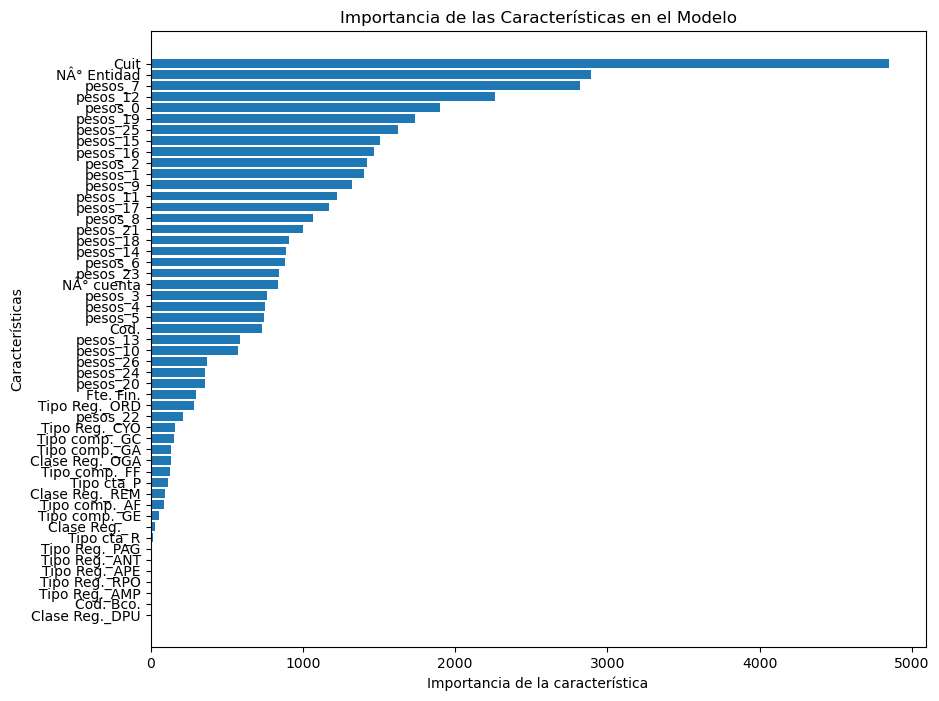

In [52]:
import matplotlib.pyplot as plt

# Asumiendo que ya has entrenado tu modelo con los mejores hiperparámetros encontrados
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Obtener la importancia de las características
importance = best_model.feature_importances_

# Crear un DataFrame para visualizar mejor
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Mostrar el DataFrame con la importancia de las variables
print(importance_df)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importancia de la característica')
plt.ylabel('Características')
plt.title('Importancia de las Características en el Modelo')
plt.gca().invert_yaxis()
plt.show()


#### OneVsRestClassifier con LogisticRegression usando los pesos y pasando el texto_limpio a tdf-idf

In [58]:
from scipy.sparse import hstack

# Definir columnas
text_column = 'texto_limpio'
target_column = 'target'

# Definir las columnas de características
numeric_features = features  # Reemplaza con tus columnas numéricas


# Imputación de valores faltantes para las columnas numéricas
numeric_imputer = SimpleImputer(strategy='median')
X_numeric = df[numeric_features]
X_numeric_imputed = numeric_imputer.fit_transform(X_numeric)

# Escalado de características numéricas
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

# Procesamiento de texto
stop_words = list(stopwords.words('spanish'))
text_processor = TfidfVectorizer(stop_words=stop_words)
X_text = df[text_column]
X_text_transformed = text_processor.fit_transform(X_text)

# Combina todas las características procesadas
X_combined = hstack([X_numeric_scaled, X_text_transformed])

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, df[target_column], test_size=0.2, random_state=42)


In [60]:
import optuna
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.preprocessing import StandardScaler

# Definir la función objetivo para Optuna
def objective(trial):
    
    # Hiperparámetros a optimizar
    C = trial.suggest_loguniform('C', 1e-5, 100.0)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Crear y ajustar el modelo
    model = OneVsRestClassifier(LogisticRegression(C=C, solver=solver, max_iter=max_iter, multi_class='ovr'))


    # Realizar validación cruzada usando Kappa como métrica
    kappa_scorer = make_scorer(cohen_kappa_score)
    kappa = cross_val_score(model, X_train, y_train, cv=3, scoring=kappa_scorer).mean()

    return kappa

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize', 
                            storage='sqlite:///ivan.db',  # Especificar la URL de almacenamiento
                            study_name="onevsrest_multinomialnb",
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)


# Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
best_params = study.best_params
best_model = OneVsRestClassifier(LogisticRegression(**best_params, multi_class='ovr'))

best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
test_kappa = cohen_kappa_score(y_test, y_pred)

print(f'Kappa en el conjunto de prueba: {test_kappa:.4f}')


[I 2024-08-18 15:59:36,316] Using an existing study with name 'onevsrest_multinomialnb' instead of creating a new one.
[I 2024-08-18 15:59:58,506] Trial 3 finished with value: 0.5754795350970733 and parameters: {'C': 0.00031509442952562327, 'solver': 'liblinear', 'max_iter': 300}. Best is trial 3 with value: 0.5754795350970733.
[I 2024-08-18 16:00:41,128] Trial 4 finished with value: 0.8660357957808665 and parameters: {'C': 0.026197046713374285, 'solver': 'liblinear', 'max_iter': 971}. Best is trial 4 with value: 0.8660357957808665.
[I 2024-08-18 16:01:58,832] Trial 5 finished with value: 0.9704427781029986 and parameters: {'C': 1.470144506955105, 'solver': 'liblinear', 'max_iter': 802}. Best is trial 5 with value: 0.9704427781029986.
[I 2024-08-18 16:02:58,934] Trial 6 finished with value: 0.9829858228553499 and parameters: {'C': 63.09394318279348, 'solver': 'lbfgs', 'max_iter': 329}. Best is trial 6 with value: 0.9829858228553499.
[I 2024-08-18 16:03:41,471] Trial 7 finished with val

Mejores hiperparámetros: {'C': 99.88252511002506, 'solver': 'liblinear', 'max_iter': 433}
Kappa en el conjunto de prueba: 0.9856


In [61]:
df.columns

Index(['NÂ° cuenta', 'Desc. Cuenta', 'NÂ° TesorerÃ­a', 'Desc. TesorerÃ­a',
       'NÂ° Entidad', 'Desc. Entidad', 'Tipo Pres.', 'Cod.', 'Fte. Fin.',
       'Cuit', 'Beneficiario', 'Descripcion', 'Cod. Bco.', 'Class',
       'texto_limpio', 'target', 'Tipo comp._AF', 'Tipo comp._FF',
       'Tipo comp._GA', 'Tipo comp._GC', 'Tipo comp._GE', 'Tipo Reg._AMP',
       'Tipo Reg._ANT', 'Tipo Reg._APE', 'Tipo Reg._CYO', 'Tipo Reg._ORD',
       'Tipo Reg._PAG', 'Tipo Reg._RPO', 'Clase Reg._   ', 'Clase Reg._DPU',
       'Clase Reg._OGA', 'Clase Reg._REM', 'Tipo cta_P', 'Tipo cta_R',
       'tokens', 'pesos_0', 'pesos_1', 'pesos_2', 'pesos_3', 'pesos_4',
       'pesos_5', 'pesos_6', 'pesos_7', 'pesos_8', 'pesos_9', 'pesos_10',
       'pesos_11', 'pesos_12', 'pesos_13', 'pesos_14', 'pesos_15', 'pesos_16',
       'pesos_17', 'pesos_18', 'pesos_19', 'pesos_20', 'pesos_21', 'pesos_22',
       'pesos_23', 'pesos_24', 'pesos_25', 'pesos_26'],
      dtype='object')

#### Red Neuronal con texto_limpio pasado a tfidf

In [63]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import to_categorical

# Parámetros
nb_classes = df['target'].nunique()  # Número de clases en la columna target
max_words = 10000  # Número máximo de palabras a considerar
batch_size = 64
nb_epochs = 20

# Separar las columnas relevantes
X_text = df['texto_limpio'].values  # Columna de texto
X_numeric = df[['NÂ° cuenta', 'NÂ° Entidad', 'Cod.', 'Fte. Fin.', 'Cuit', 'Cod. Bco.', 
                 'Tipo comp._AF', 'Tipo comp._FF', 'Tipo comp._GA', 
                'Tipo comp._GC', 'Tipo comp._GE', 'Tipo Reg._AMP', 'Tipo Reg._ANT', 
                'Tipo Reg._APE', 'Tipo Reg._CYO', 'Tipo Reg._ORD', 'Tipo Reg._PAG', 
                'Tipo Reg._RPO', 'Clase Reg._   ', 'Clase Reg._DPU', 'Clase Reg._OGA', 
                'Clase Reg._REM', 'Tipo cta_P', 'Tipo cta_R', 'pesos_0', 'pesos_1', 'pesos_2', 'pesos_3', 'pesos_4',
       'pesos_5', 'pesos_6', 'pesos_7', 'pesos_8', 'pesos_9', 'pesos_10',
       'pesos_11', 'pesos_12', 'pesos_13', 'pesos_14', 'pesos_15', 'pesos_16',
       'pesos_17', 'pesos_18', 'pesos_19', 'pesos_20', 'pesos_21', 'pesos_22',
       'pesos_23', 'pesos_24', 'pesos_25', 'pesos_26']].values  # Features numéricos y booleanos
y = df['target'].values  # Etiqueta (objetivo a predecir)

# Preprocesamiento de datos numéricos y booleanos
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Preprocesamiento de texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_text_tfidf = vectorizer.fit_transform(X_text).toarray()

# Combinar datos numéricos y texto
X_combined = np.hstack((X_numeric_scaled, X_text_tfidf))

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Convertir las etiquetas a formato one-hot si es multiclase
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Definir la red neuronal
model = Sequential()

model.add(Dense(1000, input_shape=(X_combined.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1]))  # Número de clases en la salida
model.add(Activation('softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
#model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), verbose=1)
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs, validation_data=(X_test, y_test), verbose=1)



# Hacer predicciones
y_train_predclass = model.predict(X_train, batch_size=batch_size)
y_test_predclass = model.predict(X_test, batch_size=batch_size)

# Convertir las etiquetas y las predicciones a formato ordinal
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_train_pred_labels = np.argmax(y_train_predclass, axis=1)
y_test_pred_labels = np.argmax(y_test_predclass, axis=1)

# Calcular la precisión y generar el informe de clasificación
print("Train accuracy: {}".format(round(accuracy_score(y_train_labels, y_train_pred_labels), 3)))
print("Test accuracy: {}".format(round(accuracy_score(y_test_labels, y_test_pred_labels), 3)))
print("\nTest Classification Report\n")
print(classification_report(y_test_labels, y_test_pred_labels))

Epoch 1/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.6510 - loss: 1.2521 - val_accuracy: 0.9536 - val_loss: 0.1557
Epoch 2/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 66s 113ms/step - accuracy: 0.9380 - loss: 0.2254 - val_accuracy: 0.9756 - val_loss: 0.0905
Epoch 3/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - accuracy: 0.9641 - loss: 0.1291 - val_accuracy: 0.9767 - val_loss: 0.0803
Epoch 4/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 68s 118ms/step - accuracy: 0.9708 - loss: 0.0994 - val_accuracy: 0.9807 - val_loss: 0.0704
Epoch 5/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.9747 - loss: 0.0817 - val_accuracy: 0.9834 - val_loss: 0.0726
Epoch 6/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 67s 116ms/step - accuracy: 0.9763 - loss: 0.0758 - val_accuracy: 0.9811 - val_loss: 0.0764
Epoch 7/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 66s 114ms/step - accuracy: 0.9793 - loss: 0.0686 - val_accuracy: 0.9805 - val_loss: 0.0767
Epoch 8/20
580/580 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.9812 - loss: 0